# thal2 4:3 1k Bifurcation Diagrams

# Inits

## Imports

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import thal2 as t2

from lib.util import (get_phase, freq_est,follow_phase_diffs,follow_phase_diffs_del,
                        follow_phase_diffs_u,follow_phase_diffs_u_del,
get_smallest_eps,get_largest_eps, get_es_min, get_es_max,follow_phase_diffs_v2)

from lib.rhs import _redu_c2,_full, _redu_full, _full, _full_mono_rhs

from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined, 
                            draw_quick_plot_f, add_diagram_1d_del_scatter)


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.signal import find_peaks
from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-9,'atol':1e-9,'method':'LSODA'}

In [3]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':0,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':8.5,'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws1 = {'var_names':['v','h','r','w'],
        'pardict':pd1,
        'rhs':t2.rhs,
        'coupling':t2.coupling,
        'init':np.array([-.64,0.71,0.25,0,6]),
        'TN':20000,
        'trunc_order':1,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':1}

## Defs

In [5]:
#### es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
def get_monodromy_full(es_min,phi0,a,b,mname='',tol=1e-6,recompute=False):
    """
    es_min: minimum epsilon to use
    a: nmCoupling object
    b: het. parameter.
    mnamei are the model names to save the monodromy matrix and related calculations
    """    

    kw_b = {'a':a,'b':b,'recompute':recompute,'bifdir':'bif1d_thal2/','_full_rhs':_full}
    print('es_min,phi0',es_min,phi0)
    # the _u function has the ability to save and load Y values
    _,Y = follow_phase_diffs(**dict(phi0=phi0,eps_init=es_min,eps_final=es_min-.01,deps=-1),max_time=10000,tol=tol,return_point=True,**kw_b)

    print('Y',Y)
    # define parameters for finding monodromy of full system
    pd_vdp_thal = {**a.system1.pardict,**a.system2.pardict}
    pd_vdp_thal['b']=b
    pd_vdp_thal['a']=a
    
    pd_vdp_thal['eps']=es_min
    # print(pd1['del0'])
    
    # default period must be 2*np.pi
    kws_vdp_thal = {'var_names':['v0','h0','r0','w0','v1','h1','r1','w1'],
                    'pardict':pd_vdp_thal,
                    'rhs':_full_mono_rhs,
                    'coupling':lambda x: 0*x,
                    'init':Y, # from above
                    'use_init':True, # use init for direct LC calculation
                    'TN':50000,
                    'mode':'none', # forces not normalizing period.
                    'rtol_lc':1e-10,
                    'atol_lc':1e-10,
                    'trunc_order':0,
                    'z_forward':False,
                    'i_forward':False,
                    'i_bad_dx':[False,True,False,False,False,False],
                    'save_fig':False,
                    'max_iter':50,
                    'max_time_lc':5000,
                    'tol_root_lc':1e-8,
                    'halt_after_mono':True}

    m1 = rsp(idx='',model_name=mname,**kws_vdp_thal)

    return m1

In [6]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [8]:
ss,dss=np.linspace(0,2,100,retstep=True)

In [9]:
def compute_sol_all(a,eps,phi0,b,T=2000,dt=.01):
    """
    only for use in jupyter
    """
    t = np.arange(0,T,dt)
    args = {'args':(a,eps,b), 't_eval':t,**kw_sim}

    y0a = a.system1.lc['dat'][int((phi0/(2*np.pi)) * a.system1.TN),:]
    y0b = a.system2.lc['dat'][int((0/(2*np.pi)) * a.system2.TN),:]
    y0 = np.array([y0a,y0b]).flatten()
    #a.system1.pardict['del0'] = b

    tot = 0
    for i in range(len(a.het_coeffs)):
        tot += eps**i*b**(i+1)*a.het_coeffs[i]
    a.system1.pardict['del0'] = tot
    print(a.system1.pardict['del0'])
    #print(pd1['del0'])
    
    solf = solve_ivp(_full,[0,t[-1]], y0, **args)

    args['args'] = (a,eps,b,1)
    solr_o1 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    args['args'] = (a,eps,b,2)
    solr_o2 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,3)
    #solr_o3 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,4)
    #solr_o4 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)

    return solf, solr_o1, solr_o2#, solr_o3, solr_o4


def load_sol_all(a,eps,phi0,b,T,dt=.01,path_loc='sols_temp/',recompute=True):
    if (not os.path.exists(path_loc)):
        os.makedirs(path_loc)
    
    fname_f = 'sol_f_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    fname_r = 'sol_r_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)

    fname_f = path_loc + fname_f
    fname_r = path_loc + fname_r

    print('full',fname_f)
    print('redu',fname_r)
    
    file_dne = not(os.path.isfile(fname_f))
    file_dne += not(os.path.isfile(fname_r))

    if file_dne or recompute:
        solf, solr_o1, solr_o2 = compute_sol_all(a,eps,phi0,b,T=T,dt=dt)

        # phase of full model
        ta, pha = get_phase(solf.t,solf.y.T[:,:4], skipn=200,system1=a.system1)
        tb, phb = get_phase(solf.t,solf.y.T[:,4:], skipn=200,system1=a.system2)

        dat1 = np.zeros([len(ta),2])
        dat1[:,0] = ta
        dat1[:,1] = np.mod(pha - a.om*phb,2*np.pi)

        dat2 = np.zeros([len(solr_o1.t),5])
        dat2[:,0] = solr_o1.t
        dat2[:,1] = solr_o1.y[0]
        dat2[:,2] = solr_o2.y[0]

        np.savetxt(fname_f,dat1)
        np.savetxt(fname_r,dat2)

    else:
        dat1 = np.loadtxt(fname_f)
        dat2 = np.loadtxt(fname_r)
    return dat1, dat2

## Initialize Response Functions

In [10]:
system1 = rsp(idx=0,model_name='thal0_85_1k',**kws1)
system2 = rsp(idx=1,model_name='thal1_85_1k',**kws1)

mkdir ./data/thal0_85_1k/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.02435447577890923
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/thal1_85_1k/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.02435447577890923
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# Initialize Coupling 4:3

In [11]:
het_coeffs = [1,1000]

In [12]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
nm_tup = (4,3)
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',nm_tup[0]),'_m':('om1',nm_tup[1]),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':het_coeffs, # [eps, eps^2, etc]
        }
a = nm.nmCoupling(**kw_nm)
nm_val = str(nm_tup[0])+str(nm_tup[1])

Initializing 43 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85_1k, order=0...
* Loading H thal1_85_1k, order=0...
* Loading H thal0_85_1k, order=1...
* Loading H thal1_85_1k, order=1...


### Plot 1par eps

<Axes: >

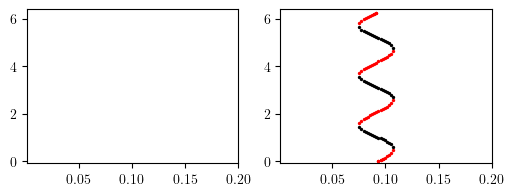

In [13]:
etup = (.001,.2,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,b=-.011,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

<Axes: >

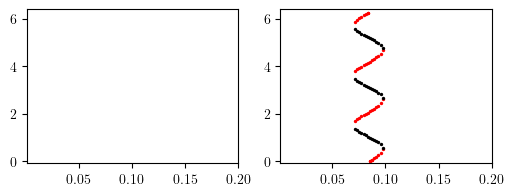

In [14]:
fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,b=-.012,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

### Plot 1par del

<Axes: >

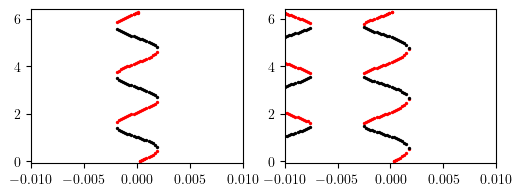

In [15]:
dtup12 = (-.01,.01,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,eps=0.1,del_tup=dtup12,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

## EPS VARY

In [16]:
kw_b = {'a':a,'b':0,'recompute':False,'bifdir':'bif1d_thal2_1k/','_full_rhs':_full}
fname_bs = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_s.txt'
fname_bu = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_u.txt'

In [17]:
mname_list = ['thal2_'+nm_val+'_b'+str(i)+'={}' for i in range(5)]

In [18]:
b_vals_full = []
e_vals_full = [] # save min eps values for all diagrams
e_hi_full = [] # save max eps values for all diagrams

## monodromy calculations
e_vals_mono_min = [] # save eps values at min monodromy
eigenvalues_min_all = []
b_min_all = []

e_vals_mono_max = [] # save eps values at max monodromy
eigenvalues_max_all = []
b_max_all = []

### b=0.0016

#### Branches eps stable

In [92]:
b=.0016
kw_b['recompute'] = False
kw_b['b'] = b

In [93]:
in_dicts = [
    dict(phi0=1,eps_init=0.1,eps_final=0,deps=-.01),
    dict(phi0=1,eps_init=0.099,eps_final=.2,deps=.005),
]

In [94]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [95]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [99]:
kw_b['recompute'] = False
kw_b['b'] = b

In [100]:
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.003,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0035,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.004,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0045,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.005,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0055,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.00601,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0065,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
kw_b['b'] = 0.0015
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0065,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.007,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.008,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=0.0016_ei=0.003_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=0.0016_ei=0.003_ef=0_de=-2.txt
[3.00000000e-03 1.56970382e+00 1.56970382e+00 1.56970382e+00 4.45911221e+00 2.36685193e+00 2.74591649e-01]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=0.0016_ei=0.0035_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=0.0016_ei=0.0035_ef=0_de=-2.txt
[3.50000000e-03 1.56950382e+00 1.56950382e+00 1.56950382e+00 4.45807911e+00 2.36715353e+00 2.74626640e-01]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=0.0016_ei=0.004_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=0.0016_ei=0.004_ef=0_de=-2.txt
[4.00000000e-03 1.56930382e+00 1.56930382e+00 1.56930382e+00 4.45784651e+00 2.36665445e+00 2.74661640e-01]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=0.0016_ei=0.0045_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=0.0016_ei=0.0045_ef=0_de=-2.txt
[0.0045     1.56915382 1.56915382 1.56915382 4.45707139 2.36668048 0.27548874]
phi init 0.3
phase_diffs_u_init=0.3_

In [ ]:
kw_b['b'] = 0.0015

In [90]:
in_dicts = [dict(phi0=.3,eps_init=0.006,eps_final=0,deps=-.001,max_iter=50,tol=1e-6),
            dict(phi0=.3,eps_init=0.00599,eps_final=0.2,deps=.0007,max_iter=50,tol=1e-6),
           ]

In [26]:
data_bu_list = []

for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=0.0016_ei=0.006_ef=0_de=-0.001.txt
phase_diffs_u_pt_init=0.3_nm=43_b=0.0016_ei=0.006_ef=0_de=-0.001.txt
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=0.0016_ei=0.00599_ef=0.2_de=0.0007.txt
phase_diffs_u_pt_init=0.3_nm=43_b=0.0016_ei=0.00599_ef=0.2_de=0.0007.txt


In [27]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

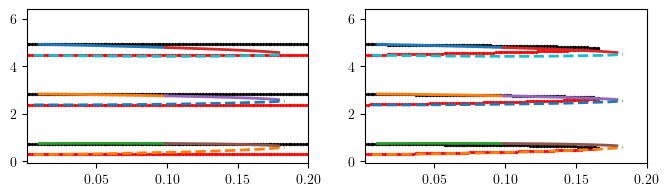

In [28]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')


In [29]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
# # add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)



# axs[1].plot(eps_list[0],np.mod(tdiffs_list[0][:,0]/np.sum(tsx_list[0],axis=1),1))
# axs[1].plot(eps_list[1],np.mod(tdiffs_list[1][:,0]/np.sum(tsx_list[1],axis=1),1))
# axs[1].plot(eps_list[2],np.mod(tdiffs_list[2][:,0]/np.sum(tsx_list[2],axis=1),1))


# T = np.sum(tsx_list[0][0,:])
# axs[1].plot(eps_list[0],3*tdiffs_list[0][:,1]/T)
# axs[1].plot(eps_list[1],3*tdiffs_list[1][:,1]/T)

# axs[1].plot(eps_list[0],6*tdiffs_list[0][:,2]/T)
# axs[1].plot(eps_list[1],6*tdiffs_list[1][:,2]/T)

# for i in range(2):
#     draw_quick_plot_f(axs[i],data_bs_list,a)
#     draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

# axs[1].set_ylim(.2,.6)

In [30]:
# es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
# print(es_min,phi0)

#### Monodromys max

In [31]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.18309000000000003 0.5870700118513241
phi init 0.5870700118513241
Y [-1.21866729e-01  3.15981995e-01  8.23432083e-02  2.93353085e-01 -3.66145703e-01  6.20209736e-01  8.16859722e-02  1.04755537e-05  6.05359359e+00]
mkdir ./data/thal2_43_b0=0.0016/
* Loading LC data...
self.T 6.053593575319261
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0012100814975887712
es_min,phi0 0.18259000000000003 0.5870700118513241
phi init 0.5870700118513241
Y [-1.34080514e-01  2.19403303e-01  7.86890126e-02  3.82292043e-01 -6.08713119e-01  4.59303781e-01  8.71992595e-02  4.93689249e-03  6.05416230e+00]
mkdir ./data/thal2_43_b1=0.0016/
* Loading LC data...
self.T 6.054162286309981
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0017841989009437641
es_min,phi0 0.18209000000000003 0.5870700118513241
phi init 0.5870700118513241
Y [-1.17964260e-01  2.23592236e-01  7.98312749e-02  3.97464916e-01 -5.14428193e-01  6.25331082e-01  8.6533592

In [32]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=0.001

#### Branches eps stable

In [33]:
b=.001
kw_b['recompute'] = False
kw_b['b'] = b

In [34]:
in_dicts = [
    dict(phi0=1,eps_init=0.1,eps_final=0,deps=-.01),
    dict(phi0=1,eps_init=0.099,eps_final=.2,deps=.01),
]

In [35]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [36]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [37]:
kw_b['recompute'] = False
kw_b['b'] = b

In [38]:
kw_b['b'] = 0
da,Yinit = follow_phase_diffs_u(**dict(phi0=6.2,eps_init=0.01,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = 0.0002
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.01,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = 0.0004
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.015,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = 0.0006
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.015,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
print(da)
kw_b['b'] = 0.0008
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.015,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = 0.001
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.015,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 6.2
phase_diffs_u_init=6.2_nm=43_b=0_ei=0.01_ef=0_de=-2.txt
phase_diffs_u_pt_init=6.2_nm=43_b=0_ei=0.01_ef=0_de=-2.txt
[0.01       1.56695382 1.56695382 1.56695382 6.2390773  4.13532596 2.04921781]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=0.0002_ei=0.01_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=0.0002_ei=0.01_ef=0_de=-2.txt
[0.01       1.56700382 1.56700382 1.56700382 6.27356205 4.16847444 2.08263334]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=0.0004_ei=0.015_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=0.0004_ei=0.015_ef=0_de=-2.txt
[0.015      1.56510381 1.56510381 1.56510381 4.19842514 2.11607372 0.02489026]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=0.0006_ei=0.015_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=0.0006_ei=0.015_ef=0_de=-2.txt
[0.015      1.56510381 1.56510381 1.56510381 4.23295035 2.15140183 0.06102129]
[0.015      1.56510381 1.56510381 1.56510381 4.23295035 2.15140183 0.06102129]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=0.0008_ei=0.015

In [39]:
in_dicts = [
    dict(phi0=.3,eps_init=0.015,eps_final=0,deps=-.002,max_iter=50),
    dict(phi0=.3,eps_init=0.01499,eps_final=0.2,deps=.006,max_iter=50),
]

In [40]:
data_bu_list = []

for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=0.001_ei=0.015_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=0.3_nm=43_b=0.001_ei=0.015_ef=0_de=-0.002.txt
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=0.001_ei=0.01499_ef=0.2_de=0.006.txt
phase_diffs_u_pt_init=0.3_nm=43_b=0.001_ei=0.01499_ef=0.2_de=0.006.txt


In [41]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

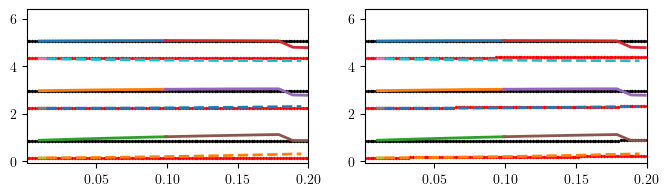

In [42]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')


In [43]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.002

#### Branches eps stable

In [44]:
b=-.002
kw_b['recompute'] = False
kw_b['b'] = b

In [45]:
in_dicts = [
    dict(phi0=1,eps_init=0.1,eps_final=0,deps=-.01),
    dict(phi0=1,eps_init=0.099,eps_final=.2,deps=.01),
]

In [46]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [47]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [54]:
kw_b['recompute'] = False
kw_b['b'] = b

In [68]:
kw_b['b'] = 0
da,Yinit = follow_phase_diffs_u(**dict(phi0=6.2,eps_init=0.01,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.02,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.03,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.04,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.045,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0499,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.055,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.06,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.065,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.07,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.075,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.08,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.085,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.09,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.095,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.1,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))

phi init 6.2
phase_diffs_u_init=6.2_nm=43_b=0_ei=0.01_ef=0_de=-2.txt
phase_diffs_u_pt_init=6.2_nm=43_b=0_ei=0.01_ef=0_de=-2.txt
[0.01       1.56702128 1.56702128 1.56702128 6.2430884  4.13800079 2.04895194]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=0_ei=0.02_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=0_ei=0.02_ef=0_de=-2.txt
[0.02       1.56302122 1.56302122 1.56302122 6.24298579 4.12447097 2.04615568]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=0_ei=0.03_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=0_ei=0.03_ef=0_de=-2.txt
[0.03       1.55952117 1.55952117 1.55952117 6.24289556 4.12164063 2.04873339]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=0_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=0_ei=0.04_ef=0_de=-2.txt
[0.04       1.55602113 1.55602113 1.55602113 6.25088101 4.11072149 2.05132271]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=0_ei=0.045_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=0_ei=0.045_ef=0_de=-2.txt
[0.045      1.5540211  1.5540211  1.554021

In [49]:
kw_b['b'] = 0
da,Yinit = follow_phase_diffs_u(**dict(phi0=6.2,eps_init=0.01,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0002
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.01,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0003
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.015,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0005
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.015,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0007
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.015,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 6.2
phase_diffs_u_init=6.2_nm=43_b=0_ei=0.01_ef=0_de=-2.txt
phase_diffs_u_pt_init=6.2_nm=43_b=0_ei=0.01_ef=0_de=-2.txt
[0.01       1.56695382 1.56695382 1.56695382 6.2390773  4.13532596 2.04921781]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0002_ei=0.01_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0002_ei=0.01_ef=0_de=-2.txt
[0.01       1.56695382 1.56695382 1.56695382 6.20619679 4.10164348 2.0163373 ]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0003_ei=0.015_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0003_ei=0.015_ef=0_de=-2.txt
[0.015      1.56510381 1.56510381 1.56510381 6.19004755 4.08200295 2.00045444]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0005_ei=0.015_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0005_ei=0.015_ef=0_de=-2.txt
[0.015      1.56510381 1.56510381 1.56510381 6.15712817 4.04988649 1.96833797]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0007_ei=0.015_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0007_ei=0.015_ef=0_

In [50]:
kw_b['b'] = -0.0009
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.015,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0011
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.015,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0013
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.015,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0015
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.015,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0017
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.015,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0019
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.015,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.002
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.015,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0009_ei=0.015_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0009_ei=0.015_ef=0_de=-2.txt
[0.015      1.56505381 1.56505381 1.56505381 6.08967741 3.9829706  1.90195779]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0011_ei=0.015_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0011_ei=0.015_ef=0_de=-2.txt
[0.015      1.56505381 1.56505381 1.56505381 6.05434817 3.94924724 1.86823442]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0013_ei=0.015_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0013_ei=0.015_ef=0_de=-2.txt
[0.015      1.56510381 1.56510381 1.56510381 6.01822445 3.9133915  1.8326459 ]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0015_ei=0.015_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0015_ei=0.015_ef=0_de=-2.txt
[0.015      1.56505381 1.56505381 1.56505381 5.97887206 3.87457406 1.79356125]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0017_ei=0.015_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.001

In [51]:
in_dicts = [
    dict(phi0=.3,eps_init=0.015,eps_final=0,deps=-.002,max_iter=50),
    dict(phi0=.3,eps_init=0.01499,eps_final=0.2,deps=.002,max_iter=50,tol=1e-6),
]

In [52]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.002_ei=0.015_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.002_ei=0.015_ef=0_de=-0.002.txt
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.002_ei=0.01499_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.002_ei=0.01499_ef=0.2_de=0.002.txt


In [53]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

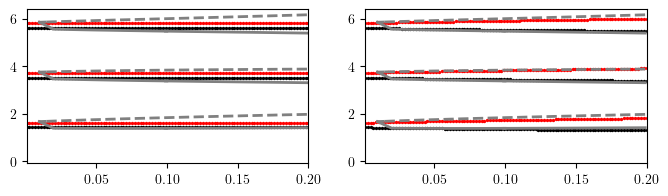

In [54]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')


In [55]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.0022

#### Branches eps stable

In [56]:
b=-.0022
kw_b['recompute'] = False
kw_b['b'] = b

In [57]:
in_dicts = [
    dict(phi0=1,eps_init=0.11,eps_final=0,deps=-.002),
    dict(phi0=1,eps_init=0.109,eps_final=.2,deps=.01),
]

In [58]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [59]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [60]:
kw_b['recompute'] = False
kw_b['b'] = b

In [61]:
kw_b['b'] = -0.002
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.015,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.002
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.018,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.002
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.022,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.002
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.026,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.002
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.03,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.002_ei=0.015_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.002_ei=0.015_ef=0_de=-2.txt
[0.015      1.56510381 1.56510381 1.56510381 5.8560363  3.75441499 1.67366939]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.002_ei=0.018_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.002_ei=0.018_ef=0_de=-2.txt
[0.018      1.56395381 1.56395381 1.56395381 5.86134672 3.75838093 1.6803237 ]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.002_ei=0.022_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.002_ei=0.022_ef=0_de=-2.txt
[0.022      1.56245381 1.56245381 1.56245381 5.86898448 3.76359764 1.68957746]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.002_ei=0.026_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.002_ei=0.026_ef=0_de=-2.txt
[0.026      1.5610038  1.5610038  1.5610038  5.87584491 3.76830114 1.69778832]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.002_ei=0.03_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.002_ei=0.03_e

In [62]:
kw_b['b'] = -0.002
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.033,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.002
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.036,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.002
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.039,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.002
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.042,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.002
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.045,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.002
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.048,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.002
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.051,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.002
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.054,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.002
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.057,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.002
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.06,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.002_ei=0.033_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.002_ei=0.033_ef=0_de=-2.txt
[0.033      1.5585038  1.5585038  1.5585038  5.88809249 3.77676484 1.71300958]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.002_ei=0.036_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.002_ei=0.036_ef=0_de=-2.txt
[0.036      1.55740379 1.55740379 1.55740379 5.8934616  3.78023927 1.71865734]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.002_ei=0.039_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.002_ei=0.039_ef=0_de=-2.txt
[0.039      1.55630379 1.55630379 1.55630379 5.8988383  3.78291116 1.72431308]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.002_ei=0.042_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.002_ei=0.042_ef=0_de=-2.txt
[0.042      1.55525379 1.55525379 1.55525379 5.9034268  3.78586912 1.7305272 ]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.002_ei=0.045_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.002_ei=0.045

In [63]:
kw_b['b'] = -0.002
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.065,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0021
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.07,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0021
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.075,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0021
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.085,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0022
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.085,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.002_ei=0.065_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.002_ei=0.065_ef=0_de=-2.txt
[0.065      1.54725377 1.54725377 1.54725377 5.94125982 3.806256   1.77277398]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0021_ei=0.07_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0021_ei=0.07_ef=0_de=-2.txt
[0.07       1.54560377 1.54560377 1.54560377 5.93195135 3.79446504 1.76592631]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0021_ei=0.075_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0021_ei=0.075_ef=0_de=-2.txt
[0.075      1.54390376 1.54390376 1.54390376 5.9405179  3.79864315 1.77478924]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0021_ei=0.085_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0021_ei=0.085_ef=0_de=-2.txt
[0.085      1.54055375 1.54055375 1.54055375 5.95853401 3.80731134 1.7931274 ]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0022_ei=0.085_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0022_ei

In [64]:
in_dicts = [
    dict(phi0=.3,eps_init=0.085,eps_final=0,deps=-.002,max_iter=50),
    dict(phi0=.3,eps_init=0.0849,eps_final=0.2,deps=.002,max_iter=50),
]

In [65]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0022_ei=0.085_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0022_ei=0.085_ef=0_de=-0.002.txt
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0022_ei=0.0849_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0022_ei=0.0849_ef=0.2_de=0.002.txt


In [66]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

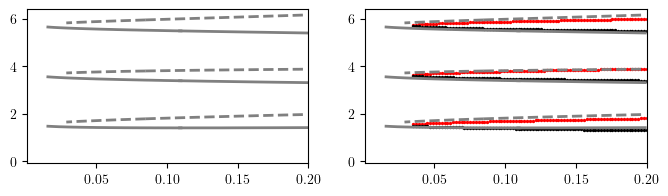

In [67]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')


#### Monodromys min

In [68]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.015999999999999917 1.468003929131413
phi init 1.468003929131413
period_est 6.260006260006261 time_est 9997.139997139999
iter, eps phase_diffs 0 0.015999999999999917 [5.64081492 3.54909637 1.47343707]                

data1 shape [[0.016      1.56502125 1.56502125 1.56502125 5.64081492 3.54909637 1.47343707]]
Y [-1.09678108e-01  2.29374759e-01  9.20946427e-02  3.99731788e-01 -5.60576943e-01  5.77879073e-01  9.85497426e-02  7.44961820e-04  6.25920897e+00]
mkdir ./data/thal2_43_b0=-0.0022/
* Computing LC data...
self.T 6.2592089885919913e-12                 
loaded coupling expansions
* Computing monodromy (augmented)...
dT: 6.228733650764576e-09
mon eval time 1.5308587551116943
* Floquet Exponent kappa = -0.0004973483768753958
es_min,phi0 0.016499999999999918 1.468003929131413
phi init 1.468003929131413
period_est 6.260006260006261 time_est 9997.519997519998
iter, eps phase_diffs 0 0.016499999999999918 [5.64081492 3.54909637 1.47343707]                

data1 shape [[0.0165

In [69]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.0023

#### Branches eps stable

In [70]:
b=-.0023
kw_b['recompute'] = False
kw_b['b'] = b

In [71]:
in_dicts = [
    dict(phi0=1,eps_init=0.11,eps_final=0,deps=-.002),
    dict(phi0=1,eps_init=0.109,eps_final=.2,deps=.01),
]

In [72]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [73]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [74]:
kw_b['recompute'] = False
kw_b['b'] = b

In [75]:
kw_b['b'] = -0.0022
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.085,eps_final=0,deps=-2),tol=1e-6,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0023
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.085,eps_final=0,deps=-2),tol=1e-6,max_iter=100,use_point=Yinit,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0022_ei=0.085_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0022_ei=0.085_ef=0_de=-2.txt
[0.085      1.54060375 1.54060375 1.54060375 5.94304662 3.79372905 1.7798144 ]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0023_ei=0.085_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0023_ei=0.085_ef=0_de=-2.txt
[0.085      1.54060375 1.54060375 1.54060375 5.9275487  3.78067816 1.76676352]


In [76]:
in_dicts = [
    dict(phi0=.3,eps_init=0.085,eps_final=0,deps=-.002,max_iter=50),
    dict(phi0=.3,eps_init=0.08499,eps_final=0.2,deps=.002,max_iter=50),
]

In [77]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0023_ei=0.085_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0023_ei=0.085_ef=0_de=-0.002.txt
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0023_ei=0.08499_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0023_ei=0.08499_ef=0.2_de=0.002.txt


In [78]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

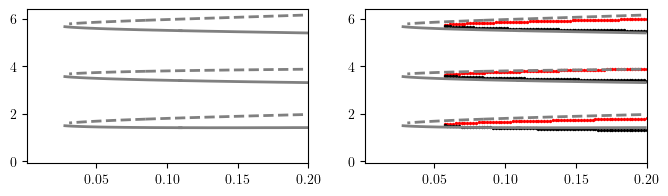

In [79]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')


#### Monodromys min

In [80]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.027999999999999928 1.4898606534583756
phi init 1.4898606534583756
period_est 6.240006240006241 time_est 9997.169997169998
iter, eps phase_diffs 0 0.027999999999999928 [5.65486678 3.55241631 1.4821873 ]                

data1 shape [[0.028      1.56002118 1.56002118 1.56002118 5.65486678 3.55241631 1.4821873 ]]
Y [-0.10717237  0.21586324  0.09137307  0.41801654 -0.3135209   0.07348958  0.09005453  0.36763336  6.24166504]
mkdir ./data/thal2_43_b0=-0.0023/
* Computing LC data...
self.T 6.2416650550010470e-09                 
loaded coupling expansions
* Computing monodromy (augmented)...
dT: 9.45556119113719e-09
mon eval time 1.5318470001220703
* Floquet Exponent kappa = (-0.0007179329947021521+0j)
es_min,phi0 0.028499999999999928 1.4898606534583756
phi init 1.4898606534583756
period_est 6.240006240006241 time_est 9997.599997599998
iter, eps phase_diffs 0 0.028499999999999928 [5.65486678 3.55241631 1.4821873 ]                

data1 shape [[0.0285     1.56002118 1.56002118 1

In [81]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.0025

#### Branches eps stable

In [82]:
b=-.0025
kw_b['recompute'] = False
kw_b['b'] = b

In [83]:
in_dicts = [
    dict(phi0=1,eps_init=0.05,eps_final=0,max_iter=50,deps=-.001),
    dict(phi0=1,eps_init=0.11,eps_final=0,deps=-.002),
    dict(phi0=1,eps_init=0.109,eps_final=.2,deps=.01),
]

In [84]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1
phi init 1


In [85]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [86]:
kw_b['recompute'] = False
kw_b['b'] = b

In [87]:
kw_b['b'] = -0.0021
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.085,eps_final=0,deps=-2),tol=1e-6,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0022
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.09,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0023
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.095,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0024
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.1,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0025
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.1,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0021_ei=0.085_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0021_ei=0.085_ef=0_de=-2.txt
[0.085      1.54055375 1.54055375 1.54055375 5.95853401 3.80731134 1.7931274 ]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0022_ei=0.09_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0022_ei=0.09_ef=0_de=-2.txt
[0.09       1.53900375 1.53900375 1.53900375 5.95249134 3.7993062  1.78983004]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0023_ei=0.095_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0023_ei=0.095_ef=0_de=-2.txt
[0.095      1.53740375 1.53740375 1.53740375 5.94806029 3.79181692 1.78760586]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0024_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0024_ei=0.1_ef=0_de=-2.txt
[0.1        1.53580374 1.53580374 1.53580374 5.9460747  3.78594849 1.78701351]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0025_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0025_ei=0.1

In [88]:
in_dicts = [
    dict(phi0=.3,eps_init=0.1,eps_final=0,deps=-.001,max_iter=30),
    dict(phi0=.3,eps_init=0.0999,eps_final=0.2,deps=.002,max_iter=30),
]

In [89]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0025_ei=0.1_ef=0_de=-0.001.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0025_ei=0.1_ef=0_de=-0.001.txt
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0025_ei=0.0999_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0025_ei=0.0999_ef=0.2_de=0.002.txt


In [90]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

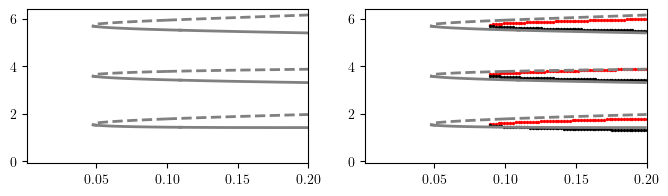

In [91]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')


#### Monodromys min

In [92]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.047999999999999945 1.5270085968327471
phi init 1.5270085968327471
period_est 6.210006210006211 time_est 9997.83999784
iter, eps phase_diffs 0 0.047999999999999945 [5.68440139 3.57652016 1.52528066]                

data1 shape [[0.048      1.55302109 1.55302109 1.55302109 5.68440139 3.57652016 1.52528066]]
Y [-0.11226422  0.23320826  0.08933643  0.39219128 -0.62747861  0.3310523   0.09117347  0.01917725  6.21324518]
mkdir ./data/thal2_43_b0=-0.0025/
* Computing LC data...
self.T 6.2132452202572372e-09                 
loaded coupling expansions
* Computing monodromy (augmented)...
dT: 8.817841514316112e-09
mon eval time 1.4933252334594727
* Floquet Exponent kappa = (-0.00076228443479353+0j)
es_min,phi0 0.048499999999999946 1.5270085968327471
phi init 1.5270085968327471
period_est 6.210006210006211 time_est 9998.309998309998
iter, eps phase_diffs 0 0.048499999999999946 [5.67630971 3.56842849 1.51718898]                

data1 shape [[0.0485     1.55302109 1.55302109 1.5530

In [93]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.003

#### Branches eps stable

In [94]:
b=-.003
kw_b['recompute'] = False
kw_b['b'] = b

In [95]:
in_dicts = [
    dict(phi0=1,eps_init=0.11,eps_final=0,max_iter=50,deps=-.002),
    dict(phi0=1,eps_init=0.109,eps_final=.2,deps=.01),
]

In [96]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [97]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [98]:
kw_b['recompute'] = False
kw_b['b'] = b

In [99]:
kw_b['b'] = -0.0025
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.1,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0026
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.11,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0027
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.12,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0028
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.13,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0029
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.14,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.003
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.15,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0025_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0025_ei=0.1_ef=0_de=-2.txt
[0.1        1.53580374 1.53580374 1.53580374 5.93298303 3.77449327 1.77555829]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0026_ei=0.11_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0026_ei=0.11_ef=0_de=-2.txt
[0.11       1.53265373 1.53265373 1.53265373 5.94620176 3.77856125 1.7896614 ]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0027_ei=0.12_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0027_ei=0.12_ef=0_de=-2.txt
[0.12       1.52960373 1.52960373 1.52960373 5.96196074 3.78486333 1.80575854]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0028_ei=0.13_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0028_ei=0.13_ef=0_de=-2.txt
[0.13       1.52660372 1.52660372 1.52660372 5.98108535 3.79312431 1.82330086]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0029_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0029_ei=0.14_e

In [100]:
in_dicts = [
    dict(phi0=.3,eps_init=0.15,eps_final=0,deps=-.001,max_iter=30),
    dict(phi0=.3,eps_init=0.14999,eps_final=0.2,deps=.002,max_iter=30),
]

In [101]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.003_ei=0.15_ef=0_de=-0.001.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.003_ei=0.15_ef=0_de=-0.001.txt
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.003_ei=0.14999_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.003_ei=0.14999_ef=0.2_de=0.002.txt


In [102]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

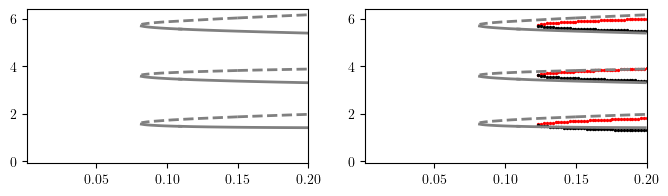

In [103]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')


#### Monodromys min

In [104]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.08199999999999993 1.6132310062247939
phi init 1.6132310062247939
period_est 6.170006170006171 time_est 9998.1999982
iter, eps phase_diffs 0 0.08199999999999993 [5.68827931 3.56943601 1.55653488]                

data1 shape [[0.082      1.54202094 1.54202094 1.54202094 5.68827931 3.56943601 1.55653488]]
Y [-0.1157456   0.22123063  0.08633145  0.40275101 -0.62612167  0.32626902  0.08900957  0.0199207   6.16744717]
mkdir ./data/thal2_43_b0=-0.003/
* Computing LC data...
self.T 6.1674471902633705e-09                 
loaded coupling expansions
* Computing monodromy (augmented)...
dT: 9.947160122909681e-09
mon eval time 1.5450928211212158
* Floquet Exponent kappa = -0.0013721908172430717
es_min,phi0 0.08249999999999993 1.6132310062247939
phi init 1.6132310062247939
period_est 6.170006170006171 time_est 9997.199997199998
iter, eps phase_diffs 0 0.08249999999999993 [5.68012991 3.56128661 1.55653488]                

data1 shape [[0.0825     1.54202094 1.54202094 1.54202094 5.68

In [105]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.004

#### Branches eps stable

In [57]:
b=-.004
kw_b['recompute'] = False
kw_b['b'] = b

In [58]:
in_dicts = [
    dict(phi0=1,eps_init=0.11,eps_final=0,max_iter=50,deps=-.002),
    dict(phi0=1,eps_init=0.109,eps_final=.2,deps=.01),
]

In [59]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [60]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [79]:
kw_b['recompute'] = False
kw_b['b'] = b

In [83]:
kw_b['b'] = -0.003
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.15,eps_final=0,deps=-2),tol=1e-6,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.004
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.15,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.14,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.13,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.12,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.115,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.11,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.105,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.103,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.101,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.003_ei=0.15_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.003_ei=0.15_ef=0_de=-2.txt
[0.15       1.5207037  1.5207037  1.5207037  6.0261891  3.81445168 1.86384224]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.004_ei=0.15_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.004_ei=0.15_ef=0_de=-2.txt
[0.15       1.5207037  1.5207037  1.5207037  6.03693171 3.82271523 1.87127943]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.004_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.004_ei=0.14_ef=0_de=-2.txt
[0.14       1.52402069 1.52402069 1.52402069 5.99458756 3.80124465 1.83877995]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.004_ei=0.13_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.004_ei=0.13_ef=0_de=-2.txt
[0.13       1.52652073 1.52652073 1.52652073 5.94566733 3.76620672 1.79254976]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.004_ei=0.12_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.004_ei=0.12_ef=0_de=-

KeyboardInterrupt: 

In [ ]:
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.095,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.09,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.085,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.08,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.075,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.07,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.065,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.06,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.055,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.05,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da,list(Yinit))


In [62]:
kw_b['b'] = -0.003
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.15,eps_final=0,deps=-2),tol=1e-6,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.004
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.15,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.003_ei=0.15_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.003_ei=0.15_ef=0_de=-2.txt
[0.15       1.5207037  1.5207037  1.5207037  6.0261891  3.81445168 1.86384224]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.004_ei=0.15_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.004_ei=0.15_ef=0_de=-2.txt
[0.15       1.5207037  1.5207037  1.5207037  6.03693171 3.82271523 1.87127943]


In [112]:
in_dicts = [
    dict(phi0=.3,eps_init=0.15,eps_final=0,deps=-.001,max_iter=30),
    dict(phi0=.3,eps_init=0.14999,eps_final=0.2,deps=.002,max_iter=30),
]

In [113]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.004_ei=0.15_ef=0_de=-0.001.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.004_ei=0.15_ef=0_de=-0.001.txt
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.004_ei=0.14999_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.004_ei=0.14999_ef=0.2_de=0.002.txt


In [114]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

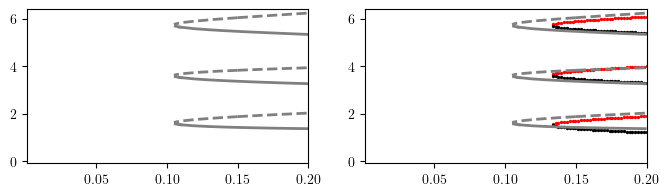

In [115]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')


#### Monodromys min

In [116]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.10499999999999995 1.618858425620573
phi init 1.618858425620573
period_est 6.130006130006131 time_est 9998.08999809
iter, eps phase_diffs 0 0.10499999999999995 [5.70993934 3.57459809 1.58666296]                

data1 shape [[0.105      1.53452083 1.53452083 1.53452083 5.70993934 3.57459809 1.58666296]]
Y [-1.21852650e-01  2.14421948e-01  8.34419640e-02  4.04684130e-01 -5.61403652e-01  5.73288915e-01  9.25211777e-02  8.15507601e-04  6.13799695e+00]
mkdir ./data/thal2_43_b0=-0.004/
* Computing LC data...
self.T 6.1379969730605690e-09                 
loaded coupling expansions
* Computing monodromy (augmented)...
dT: 8.134886741131303e-09
mon eval time 1.447596549987793
* Floquet Exponent kappa = (-0.001015031581158792+0j)
es_min,phi0 0.10549999999999995 1.618858425620573
phi init 1.618858425620573
period_est 6.130006130006131 time_est 9997.209997209999
iter, eps phase_diffs 0 0.10549999999999995 [5.69356088 3.56640886 1.57847373]                

data1 shape [[0.1055     1

In [117]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.005

#### Branches eps stable

In [118]:
b=-.005
kw_b['recompute'] = False
kw_b['b'] = b

In [119]:
in_dicts = [
    dict(phi0=1,eps_init=0.11,eps_final=0,max_iter=50,deps=-.002),
    dict(phi0=1,eps_init=0.109,eps_final=.2,deps=.01),
]

In [120]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [121]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [122]:
kw_b['recompute'] = False
kw_b['b'] = b

In [123]:
kw_b['b'] = -0.003
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.15,eps_final=0,deps=-2),tol=1e-6,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.004
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.15,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.005
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.15,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.003_ei=0.15_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.003_ei=0.15_ef=0_de=-2.txt
[0.15       1.5207037  1.5207037  1.5207037  6.0261891  3.81445168 1.86384224]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.004_ei=0.15_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.004_ei=0.15_ef=0_de=-2.txt
[0.15       1.5207037  1.5207037  1.5207037  6.03693171 3.82271523 1.87127943]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.005_ei=0.15_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.005_ei=0.15_ef=0_de=-2.txt
[0.15       1.5207037  1.5207037  1.5207037  6.10469277 3.87808097 1.92499246]


In [124]:
in_dicts = [
    dict(phi0=.3,eps_init=0.15,eps_final=0,deps=-.001,max_iter=30),
    dict(phi0=.3,eps_init=0.14999,eps_final=0.2,deps=.002,max_iter=30),
]

In [125]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.005_ei=0.15_ef=0_de=-0.001.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.005_ei=0.15_ef=0_de=-0.001.txt
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.005_ei=0.14999_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.005_ei=0.14999_ef=0.2_de=0.002.txt


In [126]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

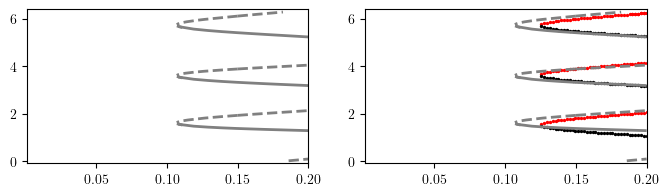

In [127]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')


#### Monodromys min

In [128]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.10699999999999996 1.6194916785822393
phi init 1.6194916785822393
period_est 6.130006130006131 time_est 9997.039997039998
iter, eps phase_diffs 0 0.10699999999999996 [5.74252008 3.61262675 1.62199569]                

data1 shape [[0.107      1.53402083 1.53402083 1.53402083 5.74252008 3.61262675 1.62199569]]
Y [-0.10534658  0.23533987  0.08526878  0.39571521 -0.26671362  0.07791935  0.08458081  0.42710312  6.13527781]
mkdir ./data/thal2_43_b0=-0.005/
* Computing LC data...
self.T 6.1352778054729178e-10                 
loaded coupling expansions
* Computing monodromy (augmented)...
dT: 1.0302393832764584e-08
mon eval time 1.5016255378723145
* Floquet Exponent kappa = (-2.5564334647220403e-08+0j)
es_min,phi0 0.10749999999999996 1.6194916785822393
phi init 1.6194916785822393
period_est 6.130006130006131 time_est 9997.789997789998
iter, eps phase_diffs 0 0.10749999999999996 [5.68498182 3.56053996 1.5672112 ]                

data1 shape [[0.1075     1.53352082 1.53352082 1.5

In [129]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.0075

#### Branches eps stable

In [130]:
b=-.0075
kw_b['recompute'] = False
kw_b['b'] = b

In [131]:
in_dicts = [
    dict(phi0=1,eps_init=0.11,eps_final=0,max_iter=50,deps=-.002),
    dict(phi0=1,eps_init=0.109,eps_final=.2,deps=.01),
]

In [132]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [133]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [134]:
kw_b['recompute'] = False
kw_b['b'] = b

In [135]:
kw_b['b'] = -0.005
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.15,eps_final=0,deps=-2),tol=1e-6,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.006
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.15,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.007
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.15,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0075
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.15,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.005_ei=0.15_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.005_ei=0.15_ef=0_de=-2.txt
[0.15       1.5207037  1.5207037  1.5207037  6.10469277 3.87808097 1.92499246]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.006_ei=0.15_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.006_ei=0.15_ef=0_de=-2.txt
[0.15       1.5207537  1.5207537  1.5207537  6.21955811 3.9717416  2.01561858]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.007_ei=0.15_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.007_ei=0.15_ef=0_de=-2.txt
[0.15       1.52105371 1.52105371 1.52105371 4.10727534 2.14534189 0.09748738]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0075_ei=0.15_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0075_ei=0.15_ef=0_de=-2.txt
[0.15       1.52130371 1.52130371 1.52130371 4.19787652 2.23234185 0.203203  ]


In [136]:
in_dicts = [
    dict(phi0=.3,eps_init=0.15,eps_final=0,deps=-.001,max_iter=30),
    dict(phi0=.3,eps_init=0.14999,eps_final=0.2,deps=.002,max_iter=30),
]

In [137]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0075_ei=0.15_ef=0_de=-0.001.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0075_ei=0.15_ef=0_de=-0.001.txt
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0075_ei=0.14999_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0075_ei=0.14999_ef=0.2_de=0.002.txt


In [138]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

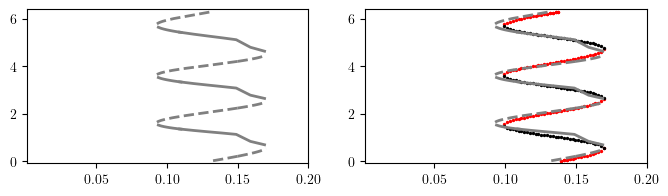

In [139]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')


#### Monodromys min

In [140]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.09299999999999994 5.774223605661879
phi init 5.774223605661879
period_est 6.15000615000615 time_est 9997.219997219998
iter, eps phase_diffs 0 0.09299999999999994 [5.67059005 3.5489685  1.54986599]                

data1 shape [[0.093      1.53852089 1.53852089 1.53852089 5.67059005 3.5489685  1.54986599]]
Y [-0.10603453  0.24425665  0.0862934   0.38533781 -0.2923006   0.07556087  0.08542916  0.39082895  6.15335738]
mkdir ./data/thal2_43_b0=-0.0075/
* Computing LC data...
self.T 6.1533573952235147e-09                 
loaded coupling expansions
* Computing monodromy (augmented)...
dT: 6.28817499619726e-09
mon eval time 1.4600625038146973
* Floquet Exponent kappa = -0.002386256110324214
es_min,phi0 0.09349999999999994 5.774223605661879
phi init 5.774223605661879
period_est 6.15000615000615 time_est 9996.899996899998
iter, eps phase_diffs 0 0.09349999999999994 [5.65404972 3.52969578 1.52790072]                

data1 shape [[0.0935     1.53802088 1.53802088 1.53802088 5.6540

#### Monodromys max

In [141]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.16999000000000003 0.5310725936247565
phi init 0.5310725936247565
period_est 6.06000606000606 time_est 9998.17999818
iter, eps phase_diffs 0 0.16999000000000003 [4.59745266 2.61350687 0.65441218]                

data1 shape [[0.16999    1.5170206  1.5170206  1.5170206  4.59745266 2.61350687 0.65441218]]
Y [-0.11042512  0.23071518  0.08146169  0.3965704  -0.53795605  0.13636822  0.08075497  0.11360126  6.06793989]
mkdir ./data/thal2_43_b0=-0.0075/
* Loading LC data...
self.T 6.153357395223514
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.002386256110324214
es_min,phi0 0.16949000000000003 0.5310725936247565
phi init 0.5310725936247565
period_est 6.06000606000606 time_est 9997.699997699998
iter, eps phase_diffs 0 0.16949000000000003 [4.61402006 2.62179057 0.67097958]                

data1 shape [[0.16949    1.5170206  1.5170206  1.5170206  4.61402006 2.62179057 0.67097958]]
Y [-1.32050773e-01  2.14446451e-01  7.97380502e-02  3.92243783e-01 

In [142]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.01

#### Branches eps stable

In [143]:
b=-.01
kw_b['recompute'] = False
kw_b['b'] = b

In [144]:
in_dicts = [
    dict(phi0=1,eps_init=0.11,eps_final=0,max_iter=50,deps=-.002),
    dict(phi0=1,eps_init=0.109,eps_final=.2,deps=.002),
]

In [145]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [146]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [147]:
kw_b['recompute'] = False
kw_b['b'] = b

In [148]:
kw_b['b'] = -0.0075
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.15,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.008
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.14,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0085
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.14,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0085
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.13,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0085
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.12,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0085
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.11,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0075_ei=0.15_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0075_ei=0.15_ef=0_de=-2.txt
[0.15       1.52130371 1.52130371 1.52130371 4.19787652 2.23234185 0.203203  ]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.008_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.008_ei=0.14_ef=0_de=-2.txt
[0.14       1.52420371 1.52420371 1.52420371 4.20637862 2.23180457 0.19786963]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0085_ei=0.14_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0085_ei=0.14_ef=0_de=-2.txt
[0.14       1.52460371 1.52460371 1.52460371 4.32891109 2.34908542 0.33546588]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0085_ei=0.13_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0085_ei=0.13_ef=0_de=-2.txt
[0.13       1.52705372 1.52705372 1.52705372 4.19893953 2.21673559 0.17528155]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0085_ei=0.12_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0085_ei=0.12_e

In [149]:
kw_b['b'] = -0.009
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.11,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0095
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.11,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.01
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.11,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.009_ei=0.11_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.009_ei=0.11_ef=0_de=-2.txt
[0.11       1.53270373 1.53270373 1.53270373 6.27170692 4.05924844 2.0624196 ]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0095_ei=0.11_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0095_ei=0.11_ef=0_de=-2.txt
[0.11       1.53290373 1.53290373 1.53290373 4.13577792 2.13838983 0.07623932]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.01_ei=0.11_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.01_ei=0.11_ef=0_de=-2.txt
[0.11       1.53310373 1.53310373 1.53310373 4.2270415  2.2266353  0.1786882 ]


In [150]:
in_dicts = [
    dict(phi0=.3,eps_init=0.11,eps_final=0.078,deps=-.001,max_iter=30),
    dict(phi0=.3,eps_init=0.10999,eps_final=0.2,deps=.002,max_iter=30),
]

In [151]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.01_ei=0.11_ef=0.078_de=-0.001.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.01_ei=0.11_ef=0.078_de=-0.001.txt
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.01_ei=0.10999_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.01_ei=0.10999_ef=0.2_de=0.002.txt


In [152]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

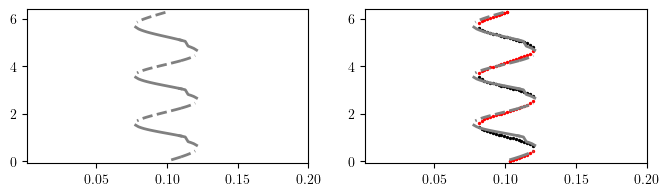

In [153]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')


#### Monodromys min

In [154]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.07799999999999997 1.5127280096436202
phi init 1.5127280096436202
period_est 6.170006170006171 time_est 9997.65999766
iter, eps phase_diffs 0 0.07799999999999997 [5.64000858 3.52933052 1.5163502 ]                

data1 shape [[0.078      1.54352096 1.54352096 1.54352096 5.64000858 3.52933052 1.5163502 ]]
Y [-1.08365823e-01  2.37074472e-01  8.80488112e-02  3.92249009e-01 -4.49374872e-01  6.55511315e-01  9.07847879e-02  3.27892598e-05  6.17295279e+00]
mkdir ./data/thal2_43_b0=-0.01/
* Computing LC data...
self.T 6.1729528079551415e-09                 
loaded coupling expansions
* Computing monodromy (augmented)...
dT: 1.021396740769017e-08
mon eval time 1.5010731220245361
* Floquet Exponent kappa = -0.0030466125602983713
es_min,phi0 0.07849999999999997 1.5127280096436202
phi init 1.5127280096436202
period_est 6.170006170006171 time_est 9997.369997369999
iter, eps phase_diffs 0 0.07849999999999997 [5.61536782 3.51011389 1.48630113]                

data1 shape [[0.0785     1

#### Monodromys max

In [155]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.12100000000000001 0.6648439057891267
phi init 0.6648439057891267
period_est 6.1200061200061215 time_est 9997.109997109997
iter, eps phase_diffs 0 0.12100000000000001 [4.67032324 2.65527165 0.66484391]                

data1 shape [[0.121      1.53102079 1.53102079 1.53102079 4.67032324 2.65527165 0.66484391]]
Y [-1.24633512e-01  2.20702069e-01  8.37766294e-02  3.93068787e-01 -6.11637696e-01  4.52784957e-01  9.00005735e-02  5.37725726e-03  6.12391632e+00]
mkdir ./data/thal2_43_b0=-0.01/
* Loading LC data...
self.T 6.1729528079551415
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0030466125602983713
es_min,phi0 0.12050000000000001 0.6648439057891267
phi init 0.6648439057891267
period_est 6.1200061200061215 time_est 9998.17999818
iter, eps phase_diffs 0 0.12050000000000001 [4.69494709 2.67168755 0.6812598 ]                

data1 shape [[0.1205     1.53102079 1.53102079 1.53102079 4.69494709 2.67168755 0.6812598 ]]
Y [-1.24719045e-01  2.14431

In [156]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.015

#### Branches eps stable

In [157]:
b=-.015
kw_b['recompute'] = False
kw_b['b'] = b

In [158]:
in_dicts = [
    dict(phi0=1,eps_init=0.07,eps_final=0,deps=-.002),
    dict(phi0=1,eps_init=0.0699,eps_final=.2,deps=.002),
]

In [159]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [160]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [161]:
kw_b['recompute'] = False
kw_b['b'] = b

#### yea 1

In [162]:
kw_b['b'] = -0.01
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.11,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.01
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.109,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.011
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.108,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.011
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.107,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.011
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.106,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0112
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.105,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0114
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.104,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0115
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.103,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.01_ei=0.11_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.01_ei=0.11_ef=0_de=-2.txt
[0.11       1.53310373 1.53310373 1.53310373 4.2270415  2.2266353  0.1786882 ]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.01_ei=0.109_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.01_ei=0.109_ef=0_de=-2.txt
[0.109      1.53335374 1.53335374 1.53335374 4.21119088 2.20967664 0.15899018]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.011_ei=0.108_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.011_ei=0.108_ef=0_de=-2.txt
[0.108      1.53445374 1.53445374 1.53445374 4.4759685  2.46401431 0.44468958]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.011_ei=0.107_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.011_ei=0.107_ef=0_de=-2.txt
[0.107      1.53465374 1.53465374 1.53465374 4.43280535 2.42275105 0.39795759]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.011_ei=0.106_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.011_ei=0.106_ef=0_

#### yea 2

In [163]:
kw_b['b'] = -0.0115
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.1025,eps_final=0,deps=-2),max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0115
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.102,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0116
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.101,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0117
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.1,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0118
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.099,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0115_ei=0.1025_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0115_ei=0.1025_ef=0_de=-2.txt
[0.1025     1.53615374 1.53615374 1.53615374 4.47428728 2.45924237 0.43601703]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0115_ei=0.102_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0115_ei=0.102_ef=0_de=-2.txt
[0.102      1.53625374 1.53625374 1.53625374 4.45027433 2.43576958 0.40981297]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0116_ei=0.101_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0116_ei=0.101_ef=0_de=-2.txt
[0.101      1.53655374 1.53655374 1.53655374 4.45185893 2.43652075 0.40891512]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0117_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0117_ei=0.1_ef=0_de=-2.txt
[0.1        1.53685374 1.53685374 1.53685374 4.45180758 2.4356363  0.40719996]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0118_ei=0.099_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0118_

#### yea 3

In [164]:
kw_b['b'] = -0.0118
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.099,eps_final=0,deps=-2),max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0118
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0985,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.01185
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.098,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0119
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0975,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.01195
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.098,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.012
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0975,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0118_ei=0.099_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0118_ei=0.099_ef=0_de=-2.txt
[0.099      1.53715374 1.53715374 1.53715374 4.45093874 2.43393468 0.40548546]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0118_ei=0.0985_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0118_ei=0.0985_ef=0_de=-2.txt
[0.0985     1.53725375 1.53725375 1.53725375 4.4293953  2.41293117 0.38175281]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.01185_ei=0.098_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.01185_ei=0.098_ef=0_de=-2.txt
[0.098      1.53740375 1.53740375 1.53740375 4.42855444 2.41126534 0.38008081]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0119_ei=0.0975_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0119_ei=0.0975_ef=0_de=-2.txt
[0.0975     1.53755375 1.53755375 1.53755375 4.42771375 2.41041713 0.37840913]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.01195_ei=0.098_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b

#### yea 4

In [165]:
kw_b['b'] = -0.012
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0975,eps_final=0,deps=-2),max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0121
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.097,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0965,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0963,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0961,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0959,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.012_ei=0.0975_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.012_ei=0.0975_ef=0_de=-2.txt
[0.0975     1.53765375 1.53765375 1.53765375 4.47237428 2.45316574 0.4249675 ]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0121_ei=0.097_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0121_ei=0.097_ef=0_de=-2.txt
[0.097      1.53790375 1.53790375 1.53790375 4.49902052 2.47871027 0.45268023]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.0965_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.0965_ef=0_de=-2.txt
[0.0965     1.53810375 1.53810375 1.53810375 4.53438378 2.51188521 0.48775263]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.0963_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.0963_ef=0_de=-2.txt
[0.0963     1.53815375 1.53815375 1.53815375 4.51585434 2.49444274 0.46894625]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.0961_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-

#### yea 5

In [166]:
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0955,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0952,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.095,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0948,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0944,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.094,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.0955_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.0955_ef=0_de=-2.txt
[0.0955     1.53825375 1.53825375 1.53825375 4.46409441 2.44403961 0.41336477]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.0952_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.0952_ef=0_de=-2.txt
[0.0952     1.53835375 1.53835375 1.53835375 4.4491005  2.42958545 0.3978173 ]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.095_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.095_ef=0_de=-2.txt
[0.095      1.53835375 1.53835375 1.53835375 4.43929802 2.41978297 0.38719795]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.0948_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.0948_ef=0_de=-2.txt
[0.0948     1.53835375 1.53835375 1.53835375 4.43031241 2.41079737 0.3765786 ]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.0944_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b

#### yea 6

In [167]:
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0935,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.093,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0925,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.092,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0915,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.091,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0905,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0903,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.0935_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.0935_ef=0_de=-2.txt
[0.0935     1.53865375 1.53865375 1.53865375 4.37962905 2.36091612 0.32096862]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.093_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.093_ef=0_de=-2.txt
[0.093      1.53875375 1.53875375 1.53875375 4.36301121 2.34402114 0.30216456]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.0925_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.0925_ef=0_de=-2.txt
[0.0925     1.53885375 1.53885375 1.53885375 4.34639553 2.32794496 0.28336294]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.092_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.092_ef=0_de=-2.txt
[0.092      1.53900375 1.53900375 1.53900375 4.33086613 2.31322469 0.26700476]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.0915_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-

#### yea 7

In [168]:
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0903,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0900001,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0895,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.08925,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.08899,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.088499,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)


phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.0903_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.0903_ef=0_de=-2.txt
[0.0903     1.53935375 1.53935375 1.53935375 4.28212538 2.26310592 0.2106164 ]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.0900001_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.0900001_ef=0_de=-2.txt
[0.0900001  1.53945375 1.53945375 1.53945375 4.27450062 2.25520416 0.20162354]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.0895_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.0895_ef=0_de=-2.txt
[0.0895     1.53955375 1.53955375 1.53955375 4.26116318 2.24240601 0.18691818]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.08925_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.08925_ef=0_de=-2.txt
[0.08925    1.53965375 1.53965375 1.53965375 4.25517314 2.23613899 0.17956039]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.08899_ef=0_de=-2.txt
phase_diffs_u_pt_init=

#### yea 7

In [169]:
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.088499,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.088,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0875,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.087,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0865,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.086,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.088499_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.088499_ef=0_de=-2.txt
[0.088499   1.53985375 1.53985375 1.53985375 4.23585068 2.21707877 0.15831905]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.088_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.088_ef=0_de=-2.txt
[0.088      1.54000375 1.54000375 1.54000375 4.22360612 2.20482684 0.14443166]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.0875_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.0875_ef=0_de=-2.txt
[0.0875     1.54010375 1.54010375 1.54010375 4.21190865 2.19203653 0.12973527]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.087_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.087_ef=0_de=-2.txt
[0.087      1.54020375 1.54020375 1.54020375 4.1993968  2.17924788 0.11504079]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.0865_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43

#### yea 7

In [170]:
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.086,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.085,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.084,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.083,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.086_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.086_ef=0_de=-2.txt
[0.086      1.54050375 1.54050375 1.54050375 4.17573847 2.1555751  0.08891492]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.085_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.085_ef=0_de=-2.txt
[0.085      1.54075375 1.54075375 1.54075375 4.1534475  2.13218461 0.06198567]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.084_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.084_ef=0_de=-2.txt
[0.084      1.54105375 1.54105375 1.54105375 4.130622   2.10934487 0.03587945]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.083_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.083_ef=0_de=-2.txt
[0.083      1.54135376 1.54135376 1.54135376 4.10862067 2.08732931 0.01059868]


#### yea 7

In [171]:
kw_b['b'] = -0.0122
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.083,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0125
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.083,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0125
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0826,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0125
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.082,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0128
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.081,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0131
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.079,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0134
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.077,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0122_ei=0.083_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0122_ei=0.083_ef=0_de=-2.txt
[0.083      1.54135376 1.54135376 1.54135376 4.10862067 2.08732931 0.01059868]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0125_ei=0.083_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0125_ei=0.083_ef=0_de=-2.txt
[0.083      1.54145376 1.54145376 1.54145376 4.15726796 2.13488488 0.06440321]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0125_ei=0.0826_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0125_ei=0.0826_ef=0_de=-2.txt
[0.0826     1.54155376 1.54155376 1.54155376 4.14803132 2.12537185 0.05298655]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0125_ei=0.082_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0125_ei=0.082_ef=0_de=-2.txt
[0.082      1.54175376 1.54175376 1.54175376 4.13363701 2.11123992 0.03749331]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0128_ei=0.081_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0

#### yea 7

In [172]:
kw_b['b'] = -0.0134
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.077,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0137
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.075,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.014
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.073,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0143
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.071,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0146
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.07,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0149
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.069,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.015
da,Yinit = follow_phase_diffs_u(**dict(phi0=.3,eps_init=0.0675,eps_final=0,deps=-2),use_point=Yinit,max_iter=100,tol=1e-6,return_point=True,**kw_b)
print(da)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0134_ei=0.077_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0134_ei=0.077_ef=0_de=-2.txt
[0.077      1.54335376 1.54335376 1.54335376 4.15377845 2.12614995 0.05211052]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0137_ei=0.075_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0137_ei=0.075_ef=0_de=-2.txt
[0.075      1.54405376 1.54405376 1.54405376 4.14782603 2.11908212 0.04394832]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.014_ei=0.073_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.014_ei=0.073_ef=0_de=-2.txt
[0.073      1.54470376 1.54470376 1.54470376 4.13835226 2.10741135 0.03091358]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0143_ei=0.071_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0143_ei=0.071_ef=0_de=-2.txt
[0.071      1.54530376 1.54530376 1.54530376 4.12536065 2.0927687  0.01382439]
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.0146_ei=0.07_ef=0_de=-2.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.0146_e

#### yea go

In [173]:
in_dicts = [
    dict(phi0=.3,eps_init=0.0675,eps_final=0.05,deps=-.001,max_iter=30),
    dict(phi0=.3,eps_init=0.067499,eps_final=0.08,deps=.001,max_iter=30),
]

In [174]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.015_ei=0.0675_ef=0.05_de=-0.001.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.015_ei=0.0675_ef=0.05_de=-0.001.txt
phi init 0.3
phase_diffs_u_init=0.3_nm=43_b=-0.015_ei=0.067499_ef=0.08_de=0.001.txt
phase_diffs_u_pt_init=0.3_nm=43_b=-0.015_ei=0.067499_ef=0.08_de=0.001.txt


In [175]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

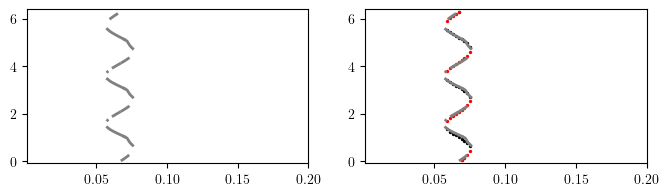

In [176]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')


#### Monodromys min

In [177]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.057499999999999996 5.8404819258562615
phi init 5.8404819258562615
period_est 6.200006200006201 time_est 9998.40999841
iter, eps phase_diffs 0 0.057499999999999996 [5.59428398 3.48908259 1.45682368]                

data1 shape [[0.0575     1.55052105 1.55052105 1.55052105 5.59428398 3.48908259 1.45682368]]
Y [-1.15343181e-01  2.38134068e-01  8.78901986e-02  3.82649423e-01 -5.58444426e-01  5.79748470e-01  9.55246996e-02  7.12137487e-04  6.20063826e+00]
mkdir ./data/thal2_43_b0=-0.015/
* Computing LC data...
self.T 6.2006382693593837e-10                 
loaded coupling expansions
* Computing monodromy (augmented)...
dT: 8.720585254937984e-09
mon eval time 1.5210537910461426
* Floquet Exponent kappa = -0.0035348984034209207
es_min,phi0 0.057999999999999996 5.8404819258562615
phi init 5.8404819258562615
period_est 6.200006200006201 time_est 9997.85999786
iter, eps phase_diffs 0 0.057999999999999996 [5.55352508 3.45372508 1.41878378]                

data1 shape [[0.058      

#### Monodromys max

In [178]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.07590000000000001 0.6612809029078086
phi init 0.6612809029078086
period_est 6.18000618000618 time_est 9996.969996969998
iter, eps phase_diffs 0 0.07590000000000001 [4.73373961 2.68814595 0.65881943]                

data1 shape [[0.0759     1.54502098 1.54502098 1.54502098 4.73373961 2.68814595 0.65881943]]
Y [-0.10860212  0.21714324  0.08832839  0.41518058 -0.54490007  0.13771162  0.08569623  0.11216371  6.17967035]
mkdir ./data/thal2_43_b0=-0.015/
* Loading LC data...
self.T 6.20063826935938
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0035348984034209207
es_min,phi0 0.07540000000000001 0.6612809029078086
phi init 0.6612809029078086
period_est 6.18000618000618 time_est 9998.149998149998
iter, eps phase_diffs 0 0.07540000000000001 [4.77440748 2.72881381 0.6994873 ]                

data1 shape [[0.0754     1.54502098 1.54502098 1.54502098 4.77440748 2.72881381 0.6994873 ]]
Y [-0.10848778  0.24139642  0.08841301  0.38687437 -0.53292745  

In [179]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

# Two parameter full

In [180]:
# fname_raw = 'thal2r_{}{}_2par_fixed.dat'
# data = np.loadtxt('../bifdat_2par/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_1k_o2_pos.dat'
data = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_1k_o2_neg.dat'
data2 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_1k_o2_neg2.dat'
data3 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

(-0.015, 0.01)

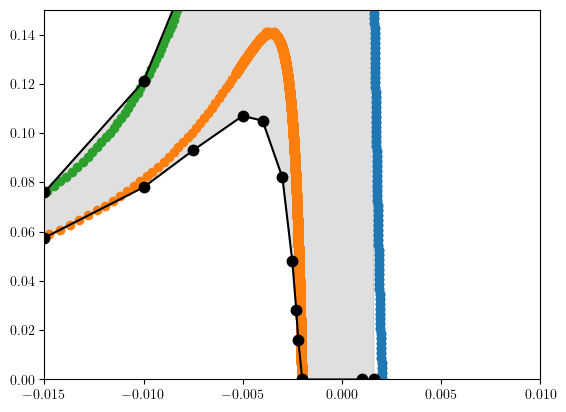

In [181]:
fig,axs = plt.subplots()
axs.fill_between(b_vals_full,e_vals_full,e_hi_full,color='gray',alpha=.25)
axs.plot(b_vals_full,e_vals_full,marker='.',color='k',markersize=15)
axs.plot(b_vals_full,e_hi_full,marker='.',color='k',markersize=15)

axs.scatter(data[:,1],data[:,0])
axs.scatter(data2[:,1],data2[:,0])
axs.scatter(data3[:,1],data3[:,0])

axs.set_ylim(0,.15)
axs.set_xlim(-.015,.01)

In [182]:
fname_lo = '../v2_bifdat_2par/full/thal2_2par_lo_{}{}.dat'.format(a._n[1],a._m[1])
fname_hi = '../v2_bifdat_2par/full/thal2_2par_hi_{}{}.dat'.format(a._n[1],a._m[1])

arr_lo = np.zeros([len(b_vals_full),2])
arr_hi = np.zeros([len(b_vals_full),2])

arr_lo[:,0] = b_vals_full
arr_lo[:,1] = e_vals_full

arr_hi[:,0] = b_vals_full
arr_hi[:,1] = e_hi_full

np.savetxt(fname_lo,arr_lo)
np.savetxt(fname_hi,arr_hi)

# Eigenvalue Convergence Plot

## Min

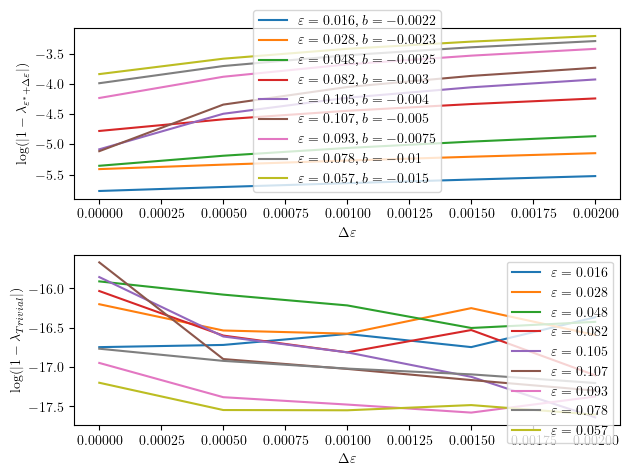

In [183]:
fig,axs = plt.subplots(2,1)

eps_values = np.arange(0,+0.0005*5,.0005)
skipn = 1
""
for j in range(len(eigenvalues_min_all[::skipn])):
    nn = len(eigenvalues_min_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_min_all[::skipn][j][i])
        
        min1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[min1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    
    ee = e_vals_mono_min[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_min_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*+\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_thal2_min_{}{}.png'.format(a._n[1],a._m[1]))

## Max

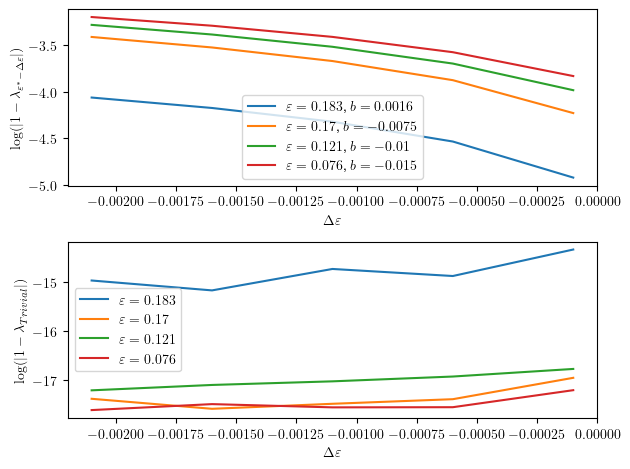

In [184]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(-0.0001,0.0001-0.0005*5,-.0005)
skipn = 1

for j in range(len(eigenvalues_max_all[::skipn])):
    nn = len(eigenvalues_max_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_max_all[::skipn][j][i])
        
        max1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[max1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    ee = e_vals_mono_max[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_max_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*-\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_thal2_max_{}{}.png'.format(a._n[1],a._m[1]))